In [3]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_15.csv')
df = df[df['round'].isin(['Sweet 16', 'Elite Eight', 'Final Four', 'Championship'])]
print(df.shape)
df.head()

(225, 79)


,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,win,wab,kenpom_adjem,...,D_D,D_F,F_S,F_A,F_B,F_C,F_D,F_F,Unnamed: 77,Unnamed: 78
3,2009,Midwest,Sweet 16,1,2009 Louisville,12,2009 Arizona,1,7.3418,9.3543,...,0,0,0,0,0,0,0,0,NaN,NaN
5,2009,Midwest,Elite Eight,1,2009 Louisville,2,2009 Michigan St.,0,0.6887,2.5847,...,0,0,0,0,0,0,0,0,NaN,NaN
6,2009,Midwest,Sweet 16,3,2009 Kansas,2,2009 Michigan St.,0,-1.9268,0.3480,...,0,0,0,0,0,0,0,0,NaN,NaN
14,2009,Final Four,Final Four,2,2009 Michigan St.,1,2009 Connecticut,1,-1.3950,-5.2572,...,0,0,0,0,0,0,0,0,NaN,NaN
15,2009,Final Four,Championship,2,2009 Michigan St.,1,2009 North Carolina,0,-0.3315,-5.7745,...,0,0,0,0,0,0,0,0,NaN,NaN


In [4]:
df['win'].value_counts(normalize=True)

1   0.5511
0   0.4489
Name: win, dtype: float64

In [5]:
df.columns

Index(['year', 'region', 'round', 'high_bracket_seed', 'high_bracket_team',
       'low_bracket_seed', 'low_bracket_team', 'win', 'wab', 'kenpom_adjem',
       'kenpom_adjoe', 'kenpom_adjde', 'barthag', 'barthag_oe', 'barthag_de',
       'off_eff', 'def_eff', 'efg%', 'ftr', 'tor', 'orb%', 'efgd%', 'ftrd',
       'tord', 'drb%', '2p%', '3p%', 'blked%', 'ast%', '3pr', 'ft%', '2p%d',
       '3p%d', 'blk%', 'ast%d', '3prd', 'ft%d', 'height', 'size', 'experience',
       'bench', 'S_S', 'S_A', 'S_B', 'S_C', 'S_D', 'S_F', 'A_S', 'A_A', 'A_B',
       'A_C', 'A_D', 'A_F', 'B_S', 'B_A', 'B_B', 'B_C', 'B_D', 'B_F', 'C_S',
       'C_A', 'C_B', 'C_C', 'C_D', 'C_F', 'D_S', 'D_A', 'D_B', 'D_C', 'D_D',
       'D_F', 'F_S', 'F_A', 'F_B', 'F_C', 'F_D', 'F_F', 'Unnamed: 77',
       'Unnamed: 78'],
      dtype='object')

In [7]:
eda_df = df[[
    'win', 
    'wab', 
    'kenpom_adjem',
    'kenpom_adjoe', 
    'kenpom_adjde', 
    'barthag', 
    'barthag_oe', 
    'barthag_de',
    'off_eff', 
    'def_eff', 
    'efg%',
    'ftr', 
    'tor', 
    'orb%', 
    'efgd%', 
    'ftrd',
    'tord', 
    'drb%', 
    '2p%', 
    '3p%', 
    'blked%', 
    'ast%', 
    '3pr', 
    'ft%', 
    '2p%d',
    '3p%d', 
    'blk%', 
    'ast%d', 
    '3prd', 
    'ft%d', 
    'height', 
    'size', 
    'experience',
    'bench', 
    'S_S', 
    'S_A', 
    'S_B', 
    'S_C', 
    'S_D',
    'S_F', 
    'A_S', 
    'A_A', 
    'A_B', 
    'A_C', 
    'A_D', 
    'A_F', 
    'B_S', 
    'B_A', 
    'B_B',
    'B_C', 
    'B_D', 
    'B_F', 
    'C_S', 
    'C_A', 
    'C_B', 
    'C_C', 
    'C_D', 
    'C_F', 
    'D_S',
    'D_A', 
    'D_B', 
    'D_C', 
    'D_D', 
    'D_F', 
    'F_S', 
    'F_A', 
    'F_B', 
    'F_C', 
    'F_D',
    'F_F']]

In [89]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(157, 70)
(68, 70)


In [90]:
train_cat = train_df[[
    'win',
    'S_S', 
    'S_A', 
    'S_B', 
    'S_C', 
    'S_D',
    'S_F', 
    'A_S', 
    'A_A', 
    'A_B', 
    'A_C', 
    'A_D', 
    'A_F', 
    'B_S', 
    'B_A', 
    'B_B',
    'B_C', 
    'B_D', 
    'B_F', 
    'C_S', 
    'C_A', 
    'C_B', 
    'C_C', 
    'C_D', 
    'C_F', 
    'D_S',
    'D_A', 
    'D_B', 
    'D_C', 
    'D_D', 
    'D_F', 
    'F_S', 
    'F_A', 
    'F_B', 
    'F_C', 
    'F_D',
    'F_F']]

train_num = train_df[[
    'win', 
    'wab', 
    'kenpom_adjem',
    'kenpom_adjoe', 
    'kenpom_adjde', 
    'barthag', 
    'barthag_oe', 
    'barthag_de',
    'off_eff', 
    'def_eff', 
    'efg%',
    'ftr', 
    'tor', 
    'orb%', 
    'efgd%', 
    'ftrd',
    'tord', 
    'drb%', 
    '2p%', 
    '3p%', 
    'blked%', 
    'ast%', 
    '3pr', 
    'ft%', 
    '2p%d',
    '3p%d', 
    'blk%', 
    'ast%d', 
    '3prd', 
    'ft%d', 
    'height', 
    'size', 
    'experience',
    'bench']]

### I. Categorical Variables

In [11]:
s_tiers = train_cat[[
 'S_S',
 'S_A',
 'S_B',
 'S_C',
 'S_D',
 'S_F']]
print(s_tiers.value_counts())
a_tiers = train_cat[[
 'A_S',
 'A_A',
 'A_B',
 'A_C',
 'A_D',
 'A_F']]
print(a_tiers.value_counts())
b_tiers = train_cat[[
 'B_S',
 'B_A',
 'B_B',
 'B_C',
 'B_D',
 'B_F']]
print(b_tiers.value_counts())
c_tiers = train_cat[[
 'C_S',
 'C_A',
 'C_B',
 'C_C',
 'C_D',
 'C_F']]
print(c_tiers.value_counts())
d_tiers = train_cat[[
 'D_S',
 'D_A',
 'D_B',
 'D_C',
 'D_D',
 'D_F']]
print(d_tiers.value_counts())
f_tiers = train_cat[[
 'F_S',
 'F_A',
 'F_B',
 'F_C',
 'F_D',
 'F_F']]
print(f_tiers.value_counts())

S_S  S_A  S_B  S_C  S_D  S_F
0    0    0    0    0    0      83
     1    0    0    0    0      32
     0    1    0    0    0      15
1    0    0    0    0    0      13
0    0    0    1    0    0      12
               0    0    1       1
                    1    0       1
dtype: int64
A_S  A_A  A_B  A_C  A_D  A_F
0    0    0    0    0    0      116
1    0    0    0    0    0       15
0    1    0    0    0    0       13
     0    0    1    0    0        6
          1    0    0    0        6
          0    0    0    1        1
dtype: int64
B_S  B_A  B_B  B_C  B_D  B_F
0    0    0    0    0    0      132
     1    0    0    0    0       10
     0    1    0    0    0        7
1    0    0    0    0    0        4
0    0    0    0    0    1        2
               1    0    0        2
dtype: int64
C_S  C_A  C_B  C_C  C_D  C_F
0    0    0    0    0    0      143
     1    0    0    0    0        5
     0    1    0    0    0        4
1    0    0    0    0    0        4
0    0    0    1    0   

In [12]:
# Remove all tier matchups that happened five or less times and view win percentage of the the remaining tiers
all_tiers = train_cat[[
 'win',
 'S_S',
 'S_A',
 'S_B',
 'S_C',
 'A_S',
 'A_A',
 'A_B',
 'A_C',
 'B_A',
 'B_B',
 'C_A']]

In [13]:
all_tiers.groupby(by=['win', 'S_S']).size()

win  S_S
0    0      61
     1       9
1    0      83
     1       4
dtype: int64

In [14]:
all_tiers.groupby(by=['win', 'S_A']).size()

win  S_A
0    0      60
     1      10
1    0      65
     1      22
dtype: int64

In [15]:
all_tiers.groupby(by=['win', 'S_B']).size()

win  S_B
0    0      65
     1       5
1    0      77
     1      10
dtype: int64

In [16]:
all_tiers.groupby(by=['win', 'S_C']).size()

win  S_C
0    0      67
     1       3
1    0      78
     1       9
dtype: int64

In [18]:
all_tiers.groupby(by=['win', 'A_S']).size()

win  A_S
0    0      61
     1       9
1    0      81
     1       6
dtype: int64

In [19]:
all_tiers.groupby(by=['win', 'A_A']).size()

win  A_A
0    0      65
     1       5
1    0      79
     1       8
dtype: int64

In [20]:
all_tiers.groupby(by=['win', 'A_B']).size()

win  A_B
0    0      67
     1       3
1    0      84
     1       3
dtype: int64

In [21]:
all_tiers.groupby(by=['win', 'A_C']).size()

win  A_C
0    0      67
     1       3
1    0      84
     1       3
dtype: int64

In [22]:
all_tiers.groupby(by=['win', 'B_A']).size()

win  B_A
0    0      63
     1       7
1    0      84
     1       3
dtype: int64

In [23]:
all_tiers.groupby(by=['win', 'B_B']).size()

win  B_B
0    0      68
     1       2
1    0      82
     1       5
dtype: int64

In [24]:
all_tiers.groupby(by=['win', 'C_A']).size()

win  C_A
0    0      67
     1       3
1    0      85
     1       2
dtype: int64

### II. Numerical Tests

/var/folders/nd/7h3lcr8d2cjbxfmfqghczqz40000gn/T/ipykernel_86499/3841579261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  box_df[numeric_columns] = scaler.fit_transform(box_df[numeric_columns])


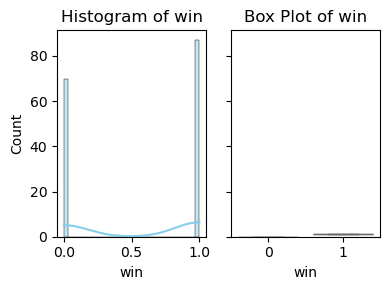

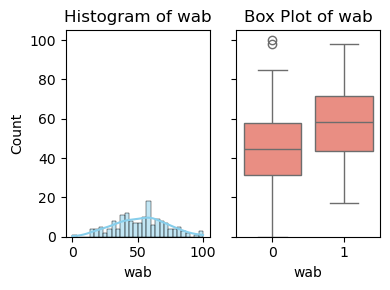

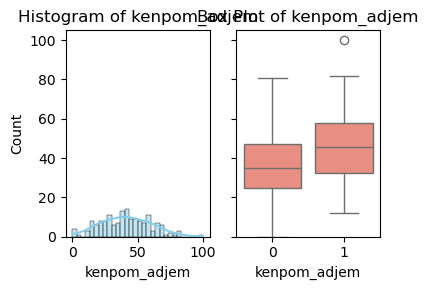

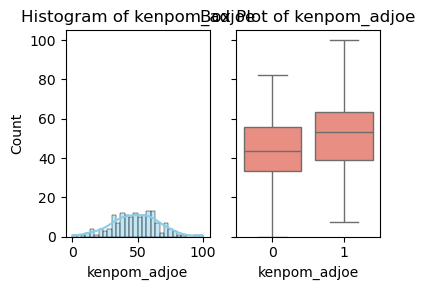

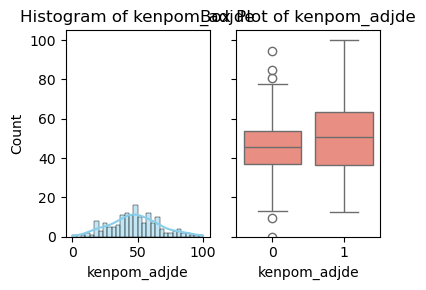

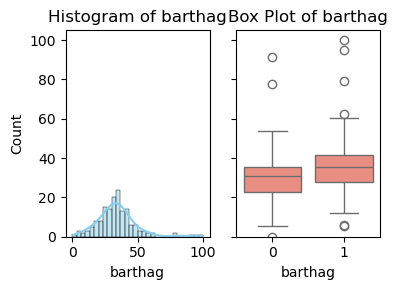

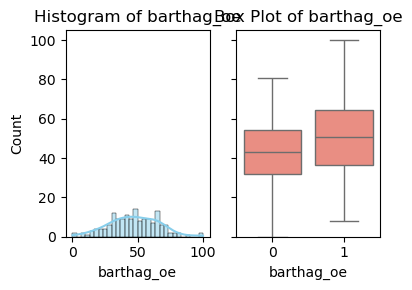

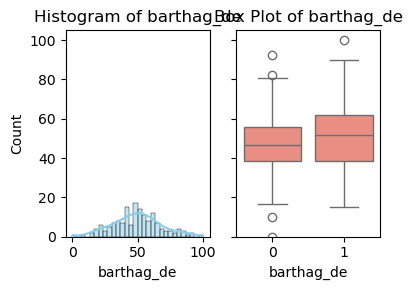

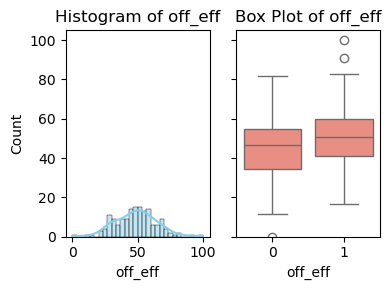

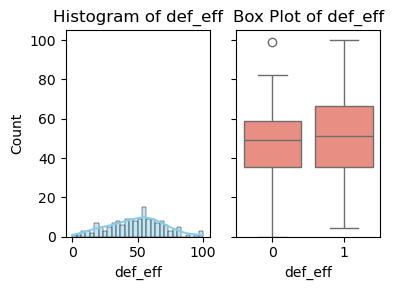

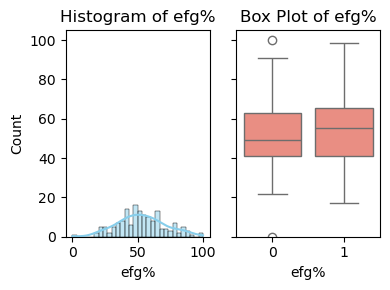

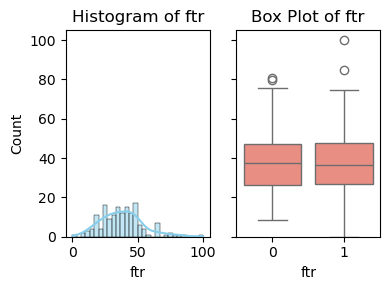

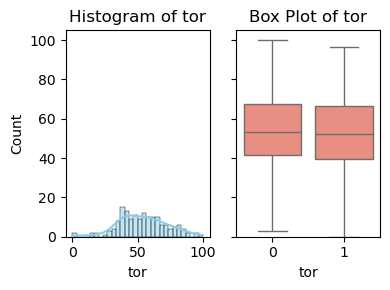

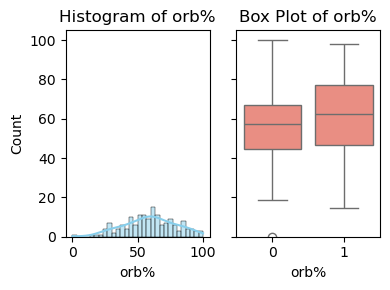

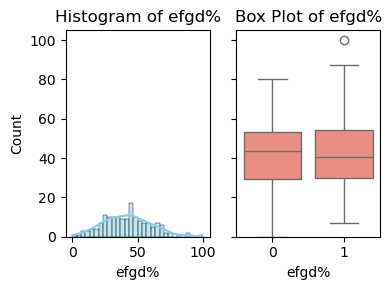

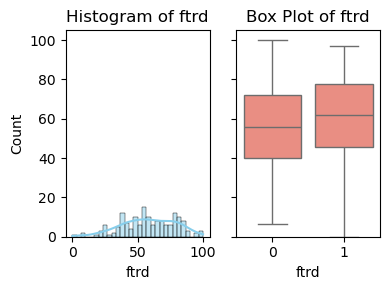

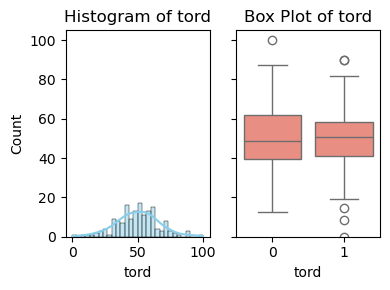

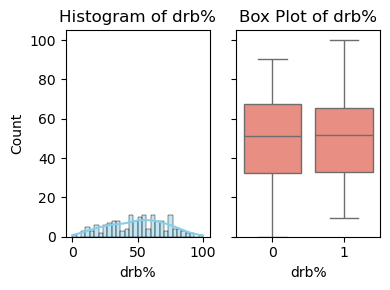

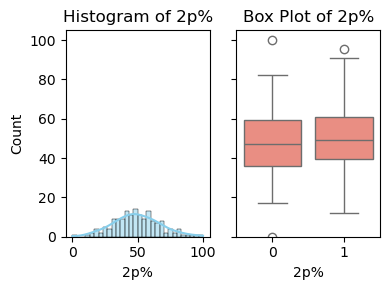

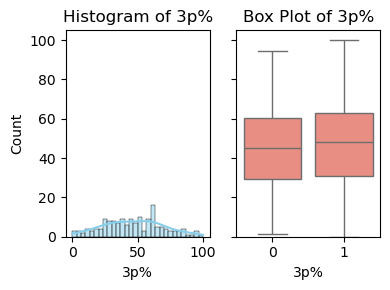

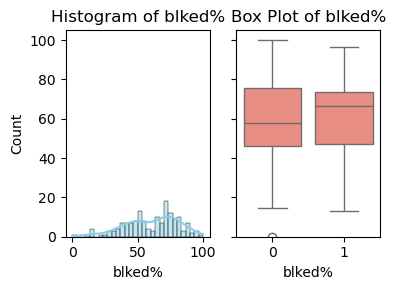

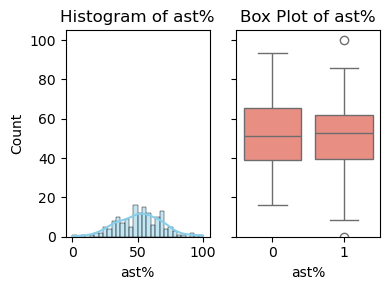

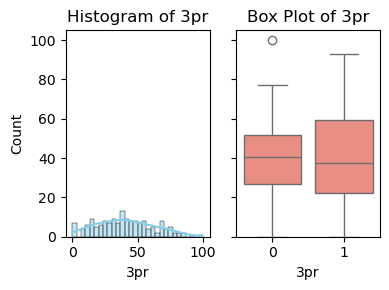

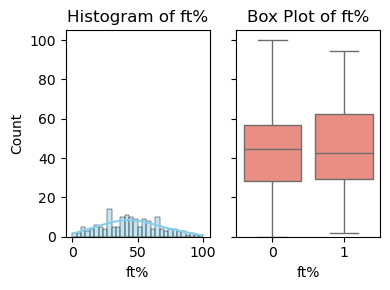

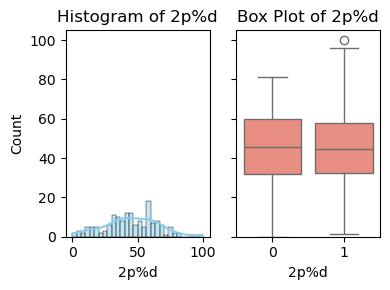

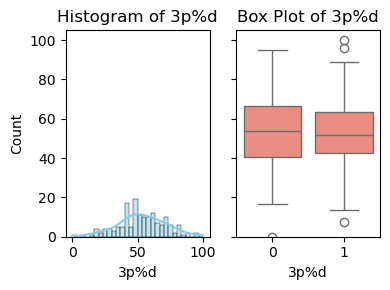

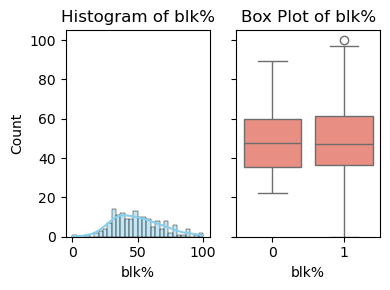

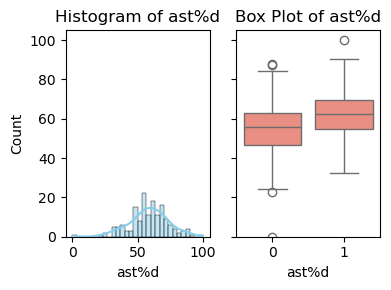

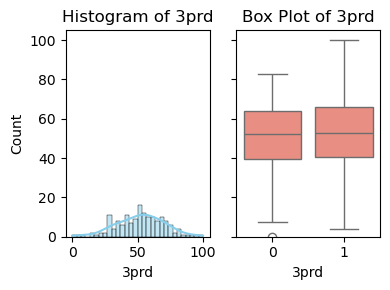

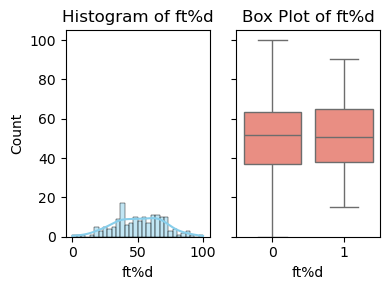

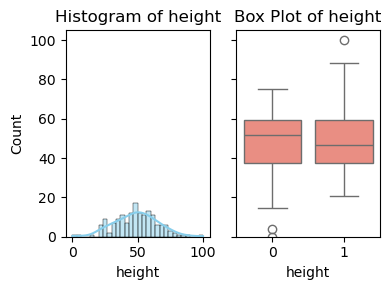

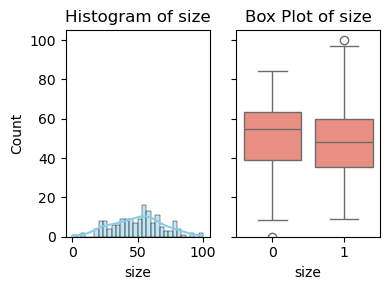

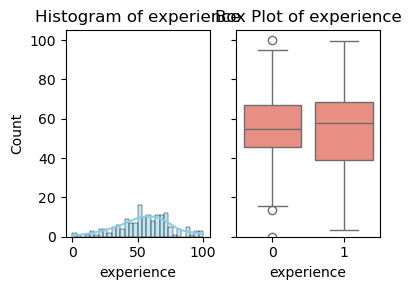

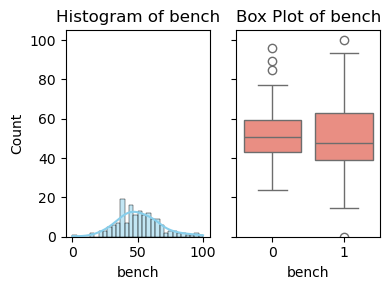

In [25]:
scaler = MinMaxScaler(feature_range=(0,100))
box_df = train_num
numeric_columns = train_num.drop(columns=['win']).columns
box_df[numeric_columns] = scaler.fit_transform(box_df[numeric_columns])

for column in box_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(4, 3), sharey=True)

    # Histogram on the left
    sns.histplot(box_df[column], kde=True, ax=axes[0], color='skyblue', bins=30)
    axes[0].set_title(f'Histogram of {column}')
    axes[0].set_xlabel(column)

    # Box plot on the right
    sns.boxplot(x='win', y=column, data=box_df, ax=axes[1], color='salmon')
    axes[1].set_title(f'Box Plot of {column}')
    axes[1].set_xlabel(column)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [26]:
corr_matrix = train_num.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 10]
print(correlation_with_target)

win            100.0000
wab             31.3600
kenpom_adjem    25.0800
kenpom_adjoe    22.0900
barthag         19.6600
barthag_oe      22.3900
barthag_de      11.3400
off_eff         17.0900
orb%            12.0700
ast%d           24.1500
Name: win, dtype: float64


In [27]:
X = train_num.drop('win', axis=1)
y = train_num['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,wab,16.9025,0.0001,0.0000
1,kenpom_adjem,10.4007,0.0015,0.0000
2,kenpom_adjoe,7.9511,0.0054,0.0653
3,kenpom_adjde,1.5554,0.2142,0.0000
4,barthag,6.2308,0.0136,0.0000
5,barthag_oe,8.1790,0.0048,0.0222
6,barthag_de,2.0184,0.1574,0.0000
7,off_eff,4.6652,0.0323,0.0000
8,def_eff,0.4034,0.5263,0.0251
9,efg%,0.7780,0.3791,0.0166


In [28]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
2,kenpom_adjoe,7.9511,0.0054,0.0653
12,orb%,2.2906,0.1322,0.0772
13,efgd%,0.0025,0.9600,0.0601
15,tord,0.2883,0.5921,0.0574
19,blked%,0.0287,0.8657,0.0540
29,height,0.1814,0.6707,0.0598
30,size,0.4499,0.5034,0.0817
32,bench,0.8261,0.3648,0.0595


In [29]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
0,wab,16.9025,0.0001,0.0000
1,kenpom_adjem,10.4007,0.0015,0.0000
2,kenpom_adjoe,7.9511,0.0054,0.0653
4,barthag,6.2308,0.0136,0.0000
5,barthag_oe,8.1790,0.0048,0.0222
7,off_eff,4.6652,0.0323,0.0000
26,ast%d,9.6032,0.0023,0.0129


In [30]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
0,wab,16.9025,0.0001,0.0000
1,kenpom_adjem,10.4007,0.0015,0.0000
2,kenpom_adjoe,7.9511,0.0054,0.0653
4,barthag,6.2308,0.0136,0.0000
5,barthag_oe,8.1790,0.0048,0.0222
26,ast%d,9.6032,0.0023,0.0129


In [32]:
# Remove any numerical variables who hit 0 criteria
# Remove any categorical variables who's win percentage is less than Round 1 win percentage
train_df = train_df[[
    'win', 
    'wab', 
    'kenpom_adjem',
    'kenpom_adjoe', 
    'barthag', 
    'barthag_oe', 
    'barthag_de',
    'off_eff', 
    'orb%', 
    'efgd%', 
    'tord', 
    'blked%', 
    'ast%d', 
    'height', 
    'size', 
    'bench',
    'S_A',
    'S_B',
    'S_C',
    'B_A']]

test_df = test_df[[
    'win', 
    'wab', 
    'kenpom_adjem',
    'kenpom_adjoe', 
    'barthag', 
    'barthag_oe', 
    'barthag_de',
    'off_eff', 
    'orb%', 
    'efgd%', 
    'tord', 
    'blked%', 
    'ast%d', 
    'height', 
    'size', 
    'bench',
    'S_A',
    'S_B',
    'S_C',
    'B_A']]

### III. Wrapper Methods

In [33]:
X_train = train_df.iloc[:,1:]
Y_train = train_df['win']

X_test = test_df.iloc[:,1:]
Y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [34]:
X_train_scaled.head()

,wab,kenpom_adjem,kenpom_adjoe,barthag,barthag_oe,barthag_de,off_eff,orb%,efgd%,tord,blked%,ast%d,height,size,bench,S_A,S_B,S_C,B_A
227,1.0036,-0.0115,-0.9712,-0.1359,-1.0697,0.9414,-1.3399,0.1672,1.3526,-1.0462,1.0024,-1.6198,1.7142,1.5214,1.8064,1,0,0,0
462,0.2537,-0.1879,1.3316,-0.3966,1.0128,-1.5664,1.3658,0.9354,-0.9484,0.4931,0.5012,0.2232,-1.4825,-0.6162,0.7268,0,0,0,0
587,-1.3353,-1.2366,-1.0728,-1.6997,-1.2556,-0.5271,-0.5110,-3.0101,-0.6928,0.7782,0.6192,-0.2340,-1.3397,-1.2414,0.5749,0,0,0,0
573,-0.1670,-0.3214,-0.3936,0.5537,-0.0835,0.3557,-0.9567,-2.0499,-2.1245,-1.0177,1.6511,-1.4627,0.7187,0.3723,-0.4564,0,0,0,0
263,0.0030,-0.2239,-0.2741,-0.0153,-0.3688,0.1375,-0.2053,0.0276,0.7901,1.0347,1.1204,0.2661,0.7145,0.6765,0.2287,1,0,0,0


In [35]:
X_test_scaled.head()

,wab,kenpom_adjem,kenpom_adjoe,barthag,barthag_oe,barthag_de,off_eff,orb%,efgd%,tord,blked%,ast%d,height,size,bench,S_A,S_B,S_C,B_A
34,0.9431,0.9645,0.4183,0.5400,0.2951,0.8966,0.0910,1.2496,-0.1814,-1.3027,-0.0590,-0.9055,-1.6673,-1.5793,-0.3205,0,0,1,0
772,-0.4549,-1.3262,-1.0343,-1.0241,-0.8031,-0.5203,-0.6813,-1.4913,-0.3604,2.6025,0.4423,0.8804,0.4708,0.1780,-1.7989,0,0,0,0
507,-0.5424,-0.7644,-1.2281,-0.5746,-1.0676,0.0297,-0.7063,0.1672,0.0487,0.0370,-0.3243,1.4662,-0.0795,0.0851,-0.9180,0,0,0,0
859,-0.7517,-0.8577,0.0675,-0.6352,0.0827,-0.7998,-0.2072,-0.4438,-1.0507,1.0347,0.0000,-1.0483,0.8993,1.4453,-1.2058,0,0,0,0
626,-0.3934,-0.6384,0.3411,-0.8583,0.1339,-1.0519,0.2772,-2.1896,-0.8206,0.7782,-0.2359,-0.7055,-0.2727,-1.6892,1.0920,0,0,0,0


In [36]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, Y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [37]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 19
selected features: 9
features with coefficients shrank to zero: 10


In [38]:
selected_feat

Index(['wab', 'barthag', 'orb%', 'efgd%', 'tord', 'blked%', 'ast%d', 'size',
       'bench'],
      dtype='object')

In [39]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_train_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {f1_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {f1_test:.2f}")

Lasso Regression F1 Score (Train): 0.73
Lasso Regression F1 Score (Test): 0.74


In [40]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [41]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [42]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['kenpom_adjoe', 'barthag', 'off_eff', 'orb%', 'blked%', 'ast%d',
       'height', 'size', 'S_B', 'B_A'], dtype=object)

In [43]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9384236453201971
Test set
Random Forests roc-auc: 0.6826503923278117


In [44]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9348111658456486
Test set
Random Forests roc-auc: 0.7114210985178727


In [45]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.5876198779424586,
 0.5361813426329556,
 0.5985178727114211,
 0.4128160418482999,
 0.46643417611159543,
 0.45292066259808195,
 0.40191804707933737,
 0.4891020052310375,
 0.4568439407149084,
 0.5422842197035745,
 0.5414123801220576,
 0.6238012205754142,
 0.4799476896251089,
 0.49389712292938104,
 0.568875326939843,
 0.5758500435919791,
 0.5379250217959896,
 0.5675675675675675,
 0.5187445510026155]

Text(0, 0.5, 'roc-auc')

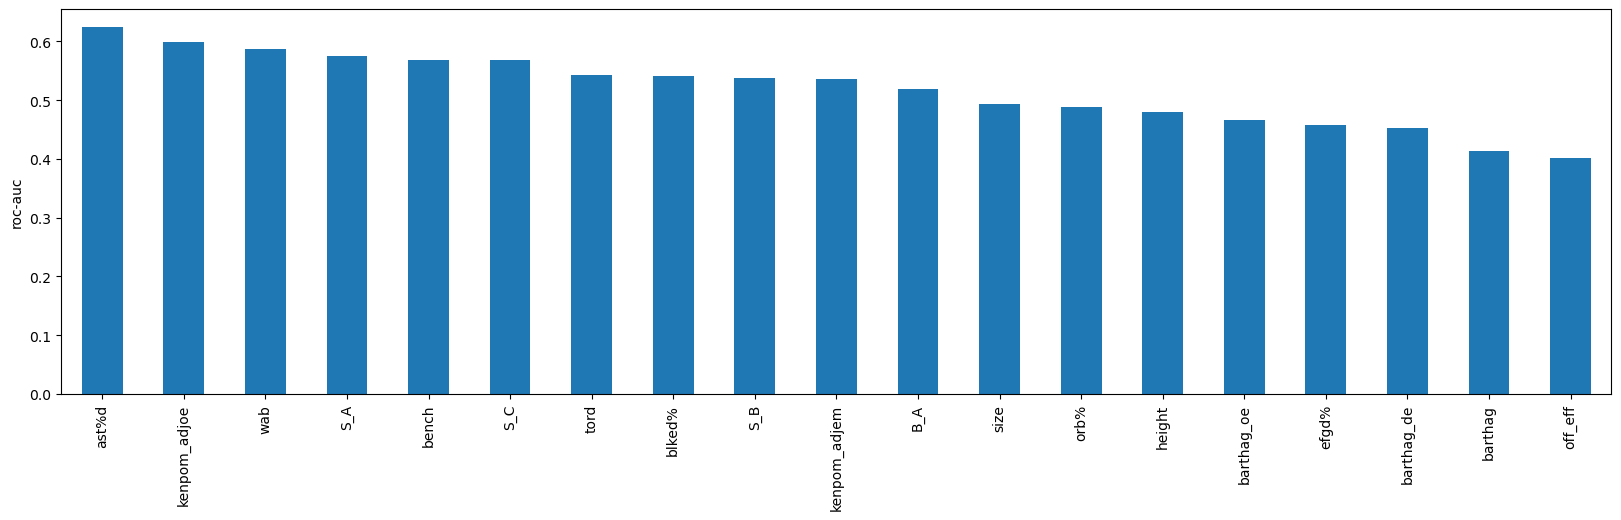

In [46]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [47]:
len(roc_values[roc_values > 0.5])

11

In [48]:
len(roc_values[roc_values > 0.6])

1

In [49]:
roc_values[roc_values > 0.5]

wab            0.5876
kenpom_adjem   0.5362
kenpom_adjoe   0.5985
tord           0.5423
blked%         0.5414
ast%d          0.6238
bench          0.5689
S_A            0.5759
S_B            0.5379
S_C            0.5676
B_A            0.5187
dtype: float64

### Exhaustive Feature Selection

In [53]:
X_train_scaled2 = X_train_scaled[[
    'wab', 
    'kenpom_adjem',
    'kenpom_adjoe', 
    'barthag', 
    'off_eff', 
    'orb%', 
    'efgd%', 
    'tord', 
    'blked%', 
    'ast%d', 
    'height', 
    'size', 
    'bench',
    'S_A',
    'S_B',
    'S_C',
    'B_A']]

X_test_scaled2 = X_test_scaled[[
    'wab', 
    'kenpom_adjem',
    'kenpom_adjoe', 
    'barthag', 
    'off_eff', 
    'orb%', 
    'efgd%', 
    'tord', 
    'blked%', 
    'ast%d', 
    'height', 
    'size', 
    'bench',
    'S_A',
    'S_B',
    'S_C',
    'B_A'
]]

In [54]:
# Initialize variables to track the best model
log_reg = LogisticRegression(solver='liblinear')
best_f1 = 0
best_features = []
best_train_f1 = 0

# Iterate over all possible subsets of features
for k in range(1, len(X_train_scaled2.columns) + 1):
    for subset in combinations(X_train_scaled2.columns, k):
        X_train_subset = X_train_scaled2[list(subset)]
        X_test_subset = X_test_scaled2[list(subset)]
        
        # Train the model with the subset of features
        log_reg.fit(X_train_subset, y_train)
        
        # Make predictions on the test set
        y_test_pred = log_reg.predict(X_test_subset)
        test_f1 = f1_score(y_test, y_test_pred)
        
        # Make predictions on the training set
        y_train_pred = log_reg.predict(X_train_subset)
        train_f1 = f1_score(y_train, y_train_pred)
        
        # Track the best subset based on test F1 score
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_features = subset
            best_train_f1 = train_f1

# Output the best feature subset and the F1 scores
print(f"Best Feature Subset: {best_features}")
print(f"Best Test F1 Score: {best_f1:.4f}")
print(f"Training F1 Score of Best Model: {best_train_f1:.4f}")

Best Feature Subset: ('kenpom_adjoe', 'barthag', 'orb%', 'efgd%', 'tord', 'blked%', 'bench', 'S_A', 'S_B', 'B_A')
Best Test F1 Score: 0.7848
Training F1 Score of Best Model: 0.6979


### V. XG Boost

In [59]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.001, 0.005, 0.01],
    'n_estimators': [500, 600, 700, 800, 900, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.1}


In [60]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=600,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [61]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.6682980442160209


In [62]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Test Data: {f1_test:.2f}")

F1 Score on Training Data: 0.82
F1 Score on Test Data: 0.59
